


**Load and explore the dataset**

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from scipy.stats import norm, boxcox
from sklearn.impute import SimpleImputer

In [142]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1


In [143]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1/CC GENERAL.csv")
print(f"shape of dataset: {df.shape}")
df.columns = df.columns.str.capitalize()

shape of dataset: (8950, 18)


In [144]:
df.head()

,Cust_id,Balance,Balance_frequency,Purchases,Oneoff_purchases,Installments_purchases,Cash_advance,Purchases_frequency,Oneoff_purchases_frequency,Purchases_installments_frequency,Cash_advance_frequency,Cash_advance_trx,Purchases_trx,Credit_limit,Payments,Minimum_payments,Prc_full_payment,Tenure
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Cust_id                           8950 non-null   object 
 1   Balance                           8950 non-null   float64
 2   Balance_frequency                 8950 non-null   float64
 3   Purchases                         8950 non-null   float64
 4   Oneoff_purchases                  8950 non-null   float64
 5   Installments_purchases            8950 non-null   float64
 6   Cash_advance                      8950 non-null   float64
 7   Purchases_frequency               8950 non-null   float64
 8   Oneoff_purchases_frequency        8950 non-null   float64
 9   Purchases_installments_frequency  8950 non-null   float64
 10  Cash_advance_frequency            8950 non-null   float64
 11  Cash_advance_trx                  8950 non-null   int64  
 12  Purcha

In [146]:
df.isna().sum().sort_values(ascending=False).head(2)
df.drop("Cust_id", axis = 1, inplace = True)


Exploring the data

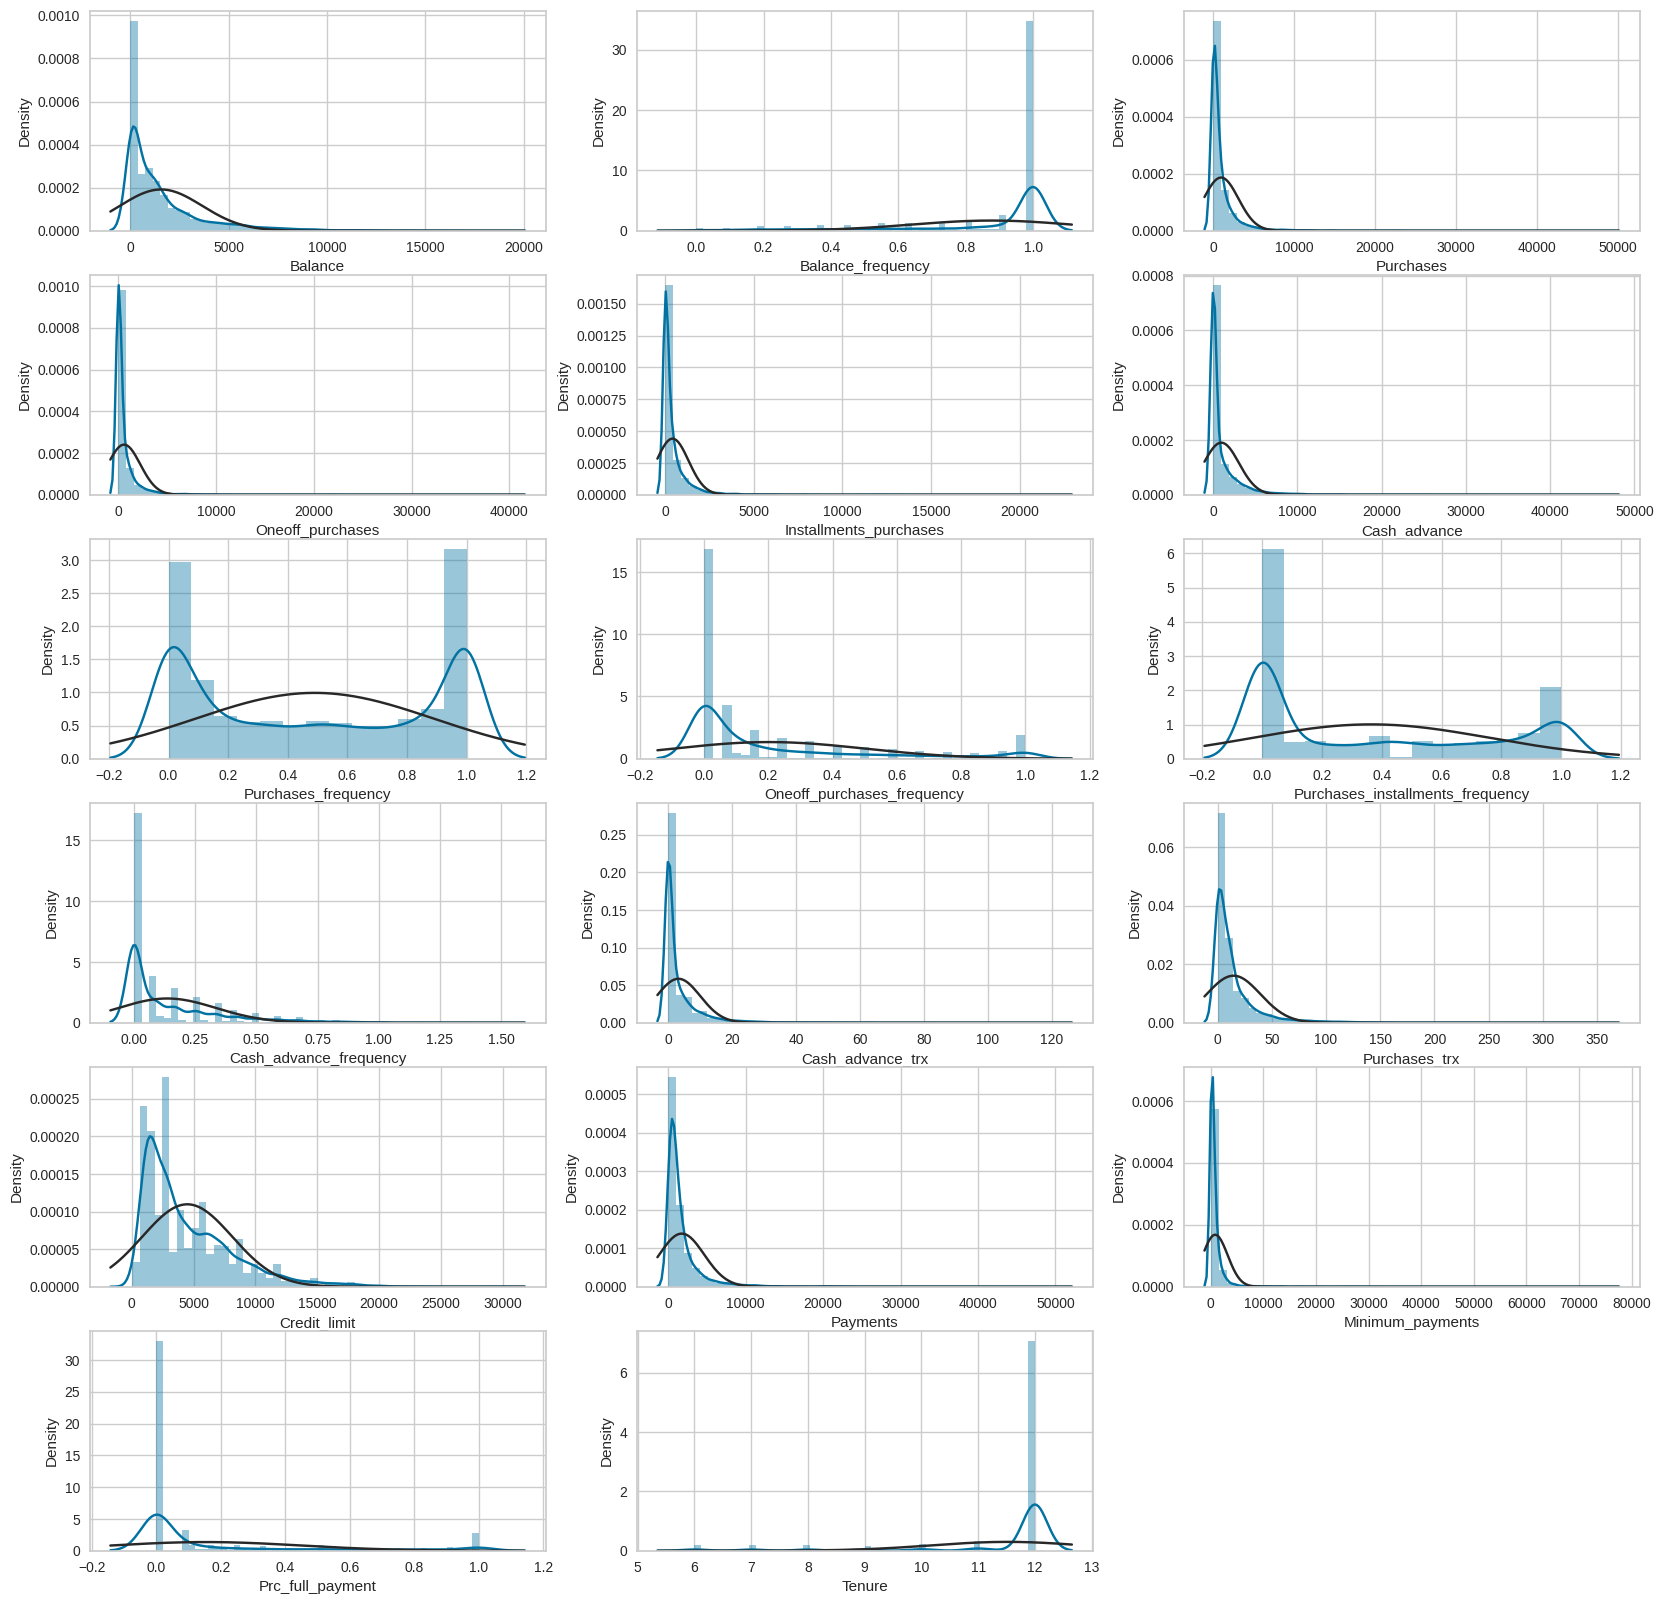

In [147]:
plt.figure(figsize=(20,20))
for i, col in enumerate(df.columns):
    ax = plt.subplot(6, 3, i+1)
    sns.distplot(df[col], ax=ax, fit=norm)
    plt.xlabel(col)
plt.show()

Data PreProcessing


1- Drop unnecessary columns

In [148]:
df.drop("Oneoff_purchases", axis = 1, inplace = True)
df.drop("Purchases_frequency", axis = 1, inplace = True)
df.drop("Oneoff_purchases_frequency", axis = 1, inplace = True)
df.drop("Minimum_payments", axis = 1, inplace = True)



2- Handle missing data according to info

In [149]:
df = df.dropna(subset=['Credit_limit'])

print(df.isnull().sum())


Balance                             0
Balance_frequency                   0
Purchases                           0
Installments_purchases              0
Cash_advance                        0
Purchases_installments_frequency    0
Cash_advance_frequency              0
Cash_advance_trx                    0
Purchases_trx                       0
Credit_limit                        0
Payments                            0
Prc_full_payment                    0
Tenure                              0
dtype: int64


Data Normalization

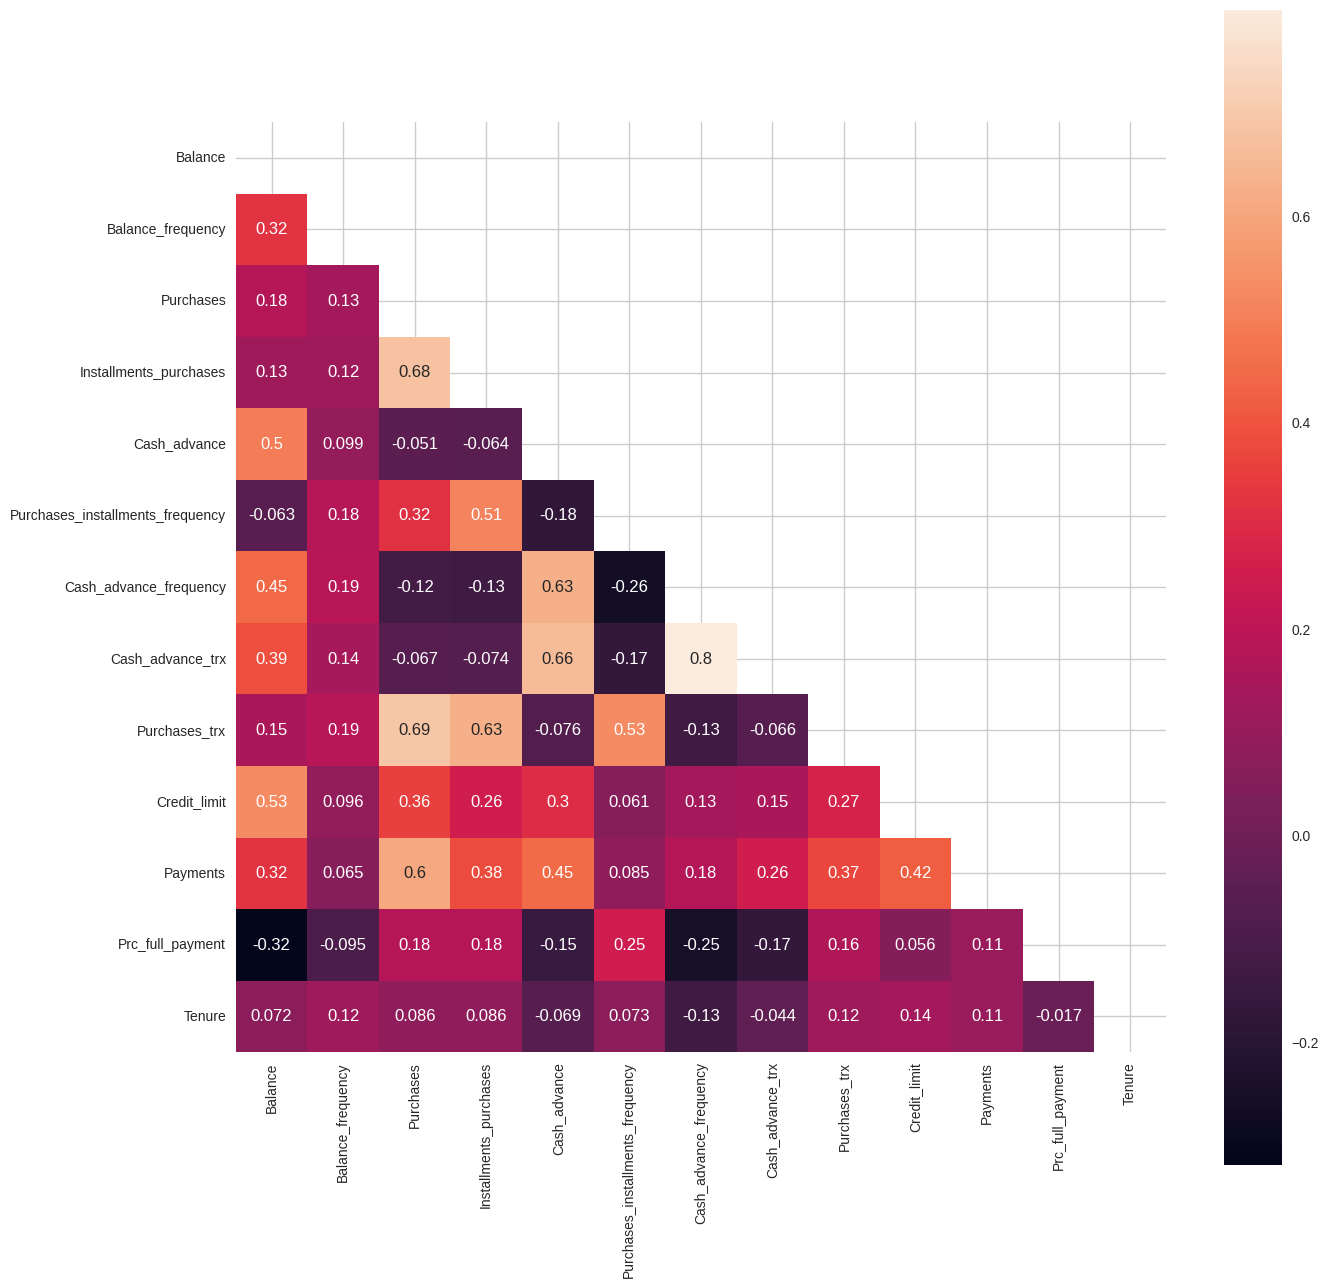

In [150]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)  # Convert back to DataFrame

# Visualize the correlation of normalized data
plt.figure(figsize=(15,15))
sns.heatmap(df_scaled.corr(), annot=True, mask=np.triu(df_scaled.corr()), square=True)
plt.show()


Outlier Removal and Detection

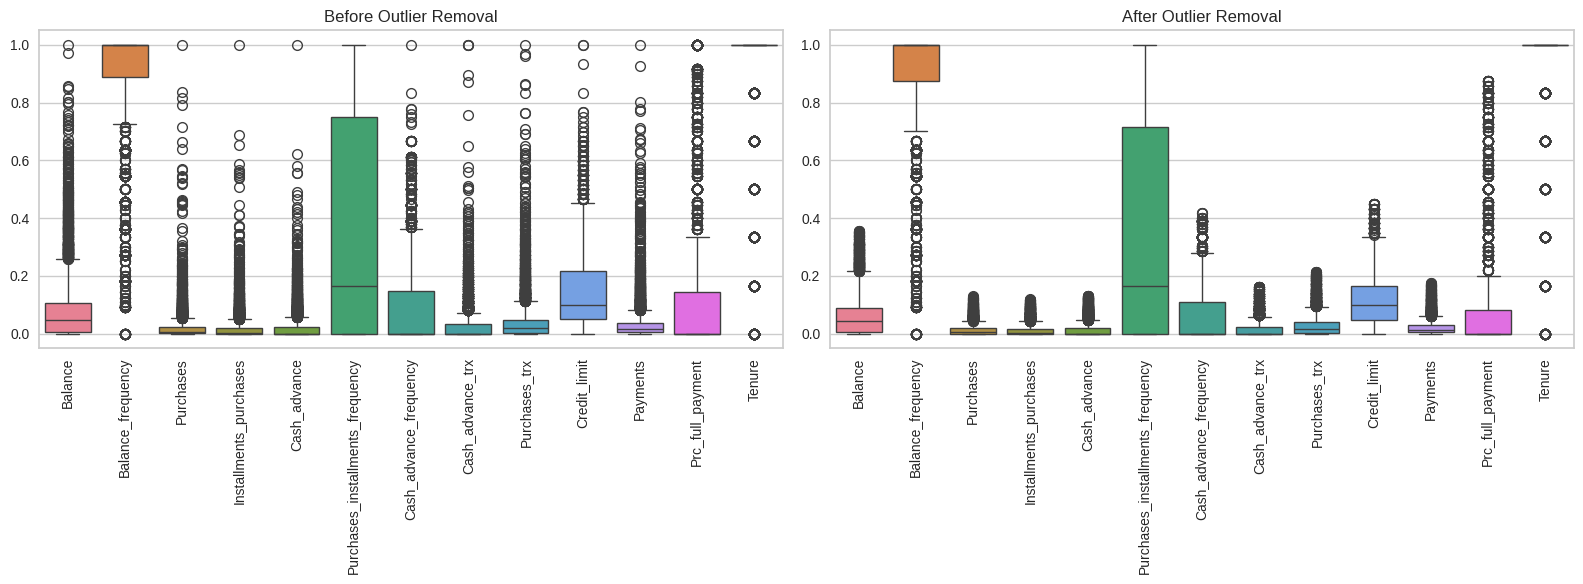

In [151]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Apply Z-score method for outlier removal
from scipy.stats import zscore
z_scores = zscore(df_scaled)
df_cleaned = df_scaled[(z_scores < 2.5).all(axis=1)]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_scaled)
plt.title("Before Outlier Removal")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned)
plt.title("After Outlier Removal")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


PCA: Reduce Data dimensionality

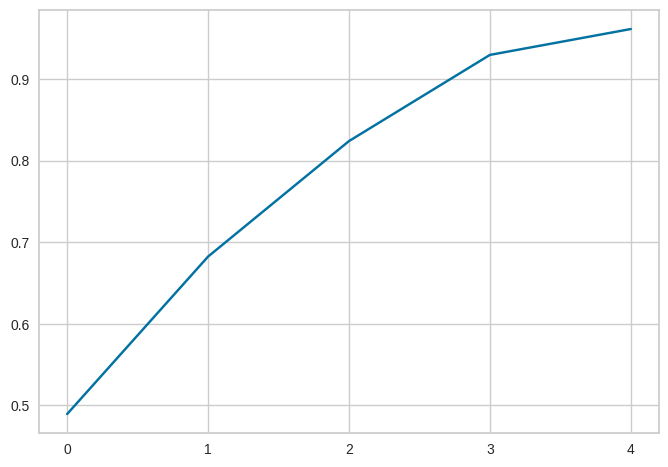

In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(df_cleaned)
plt.xticks(range(0,17))
sns.lineplot(data=pca.explained_variance_ratio_.cumsum())
plt.show()


In [153]:
pca = PCA(n_components = 2)
train_df = pca.fit_transform(df_cleaned)

**Modeling**


K-means clustering

Use Elbow method to determine the optimal number of clusters.

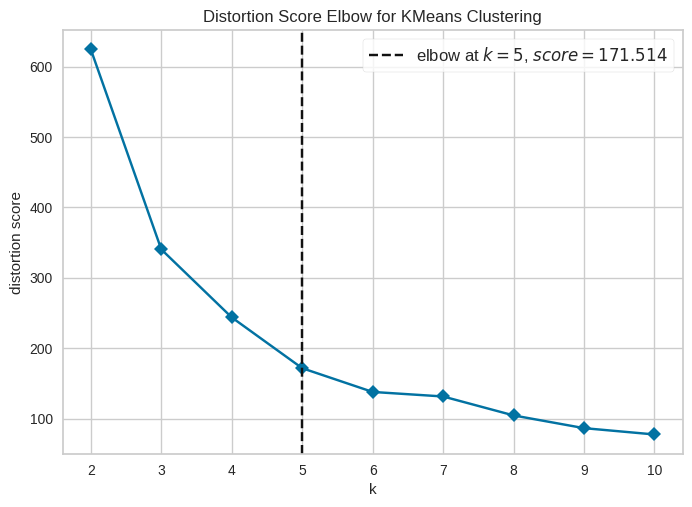

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [154]:
kmeans_model = KMeans()
elbow = KElbowVisualizer(kmeans_model, k=10, timings=False)
elbow.fit(train_df)
elbow.show()

In [155]:
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(train_df)
labels_km_pca = kmeans_model.labels_
print(labels_km_pca)

[0 0 0 ... 0 0 0]


In [156]:
data = pd.DataFrame(columns=['x', 'y'], data=train_df)
data['cluster'] = kmeans_model.predict(data)

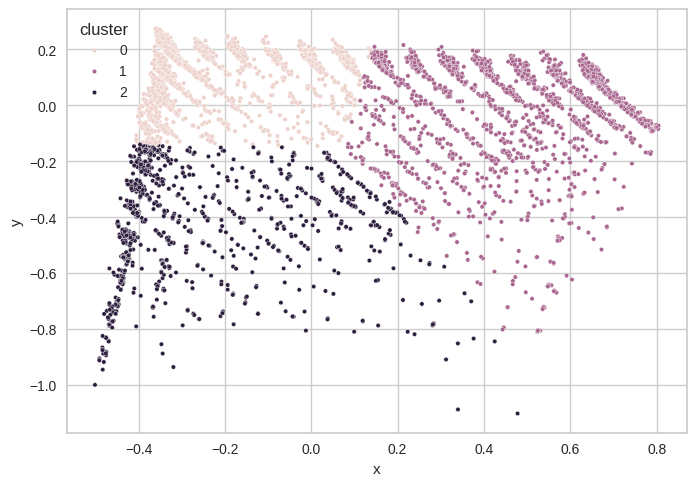

In [157]:
sns.scatterplot(data=data, x='x', y='y', hue='cluster',s=10)
plt.show()

In [158]:
silhouette = metrics.silhouette_score(data[['x', 'y']], data['cluster'])
print('Silhouette score:',silhouette)

Silhouette score: 0.6004302989753474


Without PCA

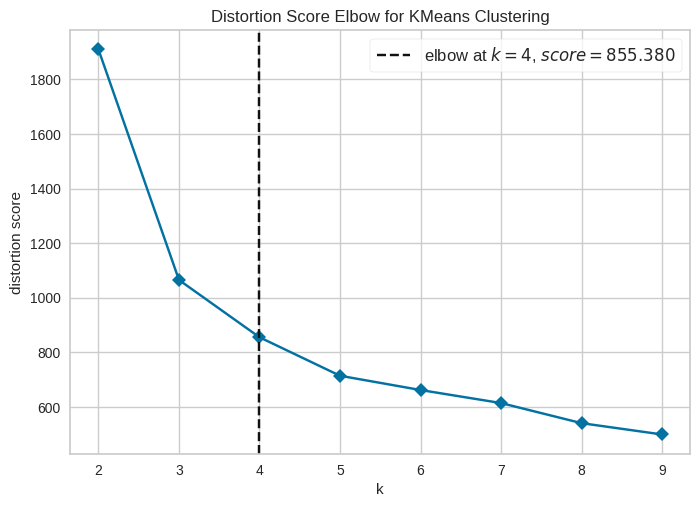

Cluster Labels: [0 0 0 ... 0 0 0]


In [159]:
kmeans_model = KMeans()
elbow = KElbowVisualizer(kmeans_model, k=(2, 10), timings=False)
elbow.fit(df_cleaned)
elbow.show()

# Choose the optimal number of clusters from the Elbow visualizer
optimal_clusters = elbow.elbow_value_

# Fit KMeans with the optimal number of clusters
kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_model.fit(df_cleaned)
labels_km = kmeans_model.labels_

print("Cluster Labels:", labels)

In [160]:
df_cleaned['Cluster'] = labels_km
print(df_cleaned.head())

    Balance  Balance_frequency  Purchases  Installments_purchases  \
0  0.002148           0.818182   0.001945                0.004240   
2  0.131026           1.000000   0.015766                0.000000   
3  0.087521           0.636364   0.030567                0.000000   
4  0.042940           1.000000   0.000326                0.000000   
5  0.095038           1.000000   0.027188                0.059257   

   Cash_advance  Purchases_installments_frequency  Cash_advance_frequency  \
0      0.000000                          0.083333                0.000000   
2      0.000000                          0.000000                0.000000   
3      0.004366                          0.000000                0.055555   
4      0.000000                          0.000000                0.000000   
5      0.000000                          0.583333                0.000000   

   Cash_advance_trx  Purchases_trx  Credit_limit  Payments  Prc_full_payment  \
0           0.00000       0.005587      0.


**Hierarchical Clustering**



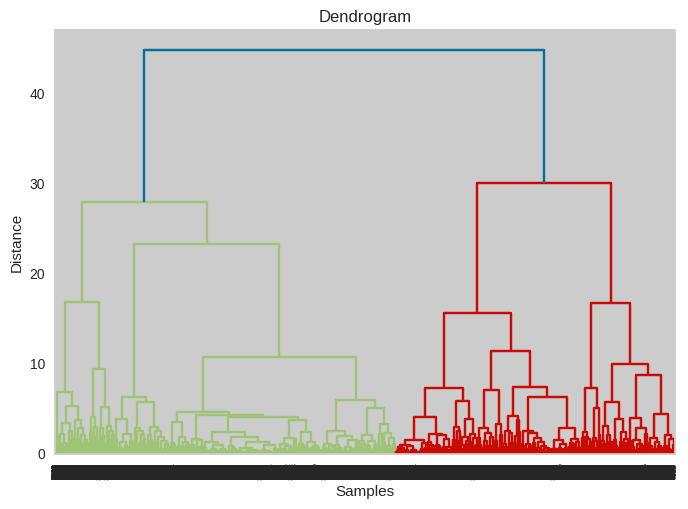

In [161]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(df_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


In [162]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
labels_h = agg_clustering.fit_predict(df_scaled)


with PCA

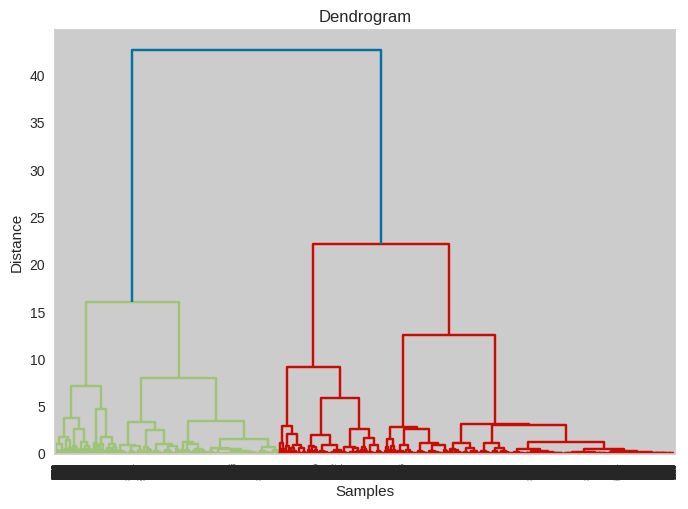

In [163]:
linkage_matrix = linkage(train_df, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
labels_h_pca = agg_clustering.fit_predict(train_df)

Spectral clustering

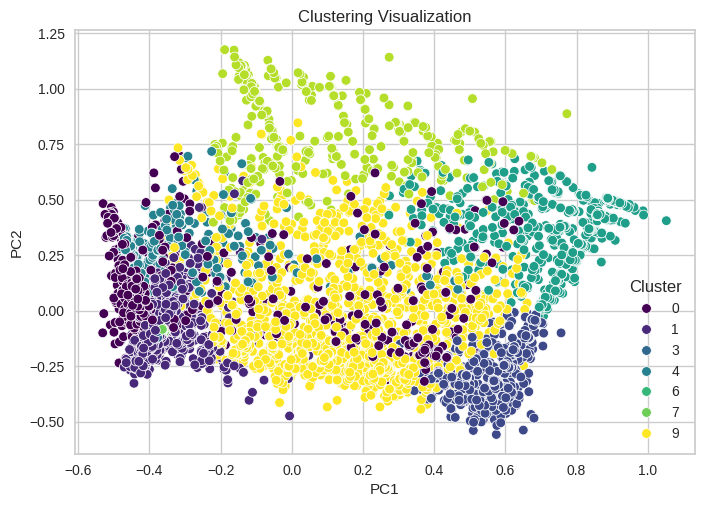

In [164]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
labels_spectral = spectral_clustering.fit_predict(df_scaled)
pca_2d = PCA(n_components=2).fit_transform(df_scaled)
df_clusters = pd.DataFrame(pca_2d, columns=['PC1', 'PC2'])
df_clusters['Cluster'] = labels_spectral
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title("Clustering Visualization")
plt.show()

Spectral Clustering with PCA reduction

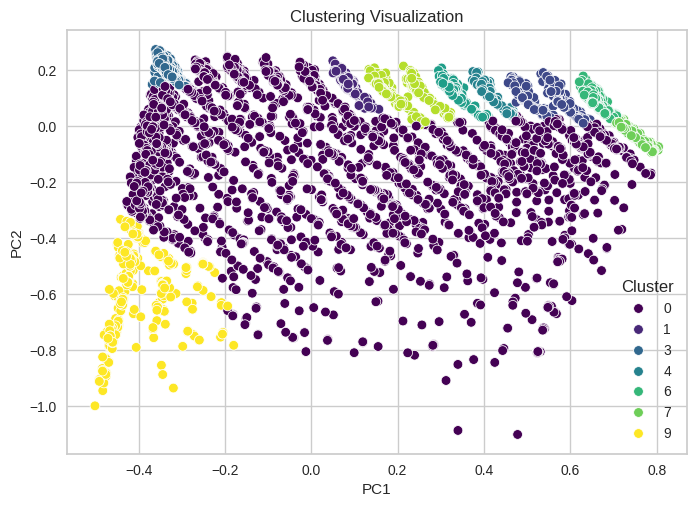

In [165]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors')
labels_spectral_pca = spectral_clustering.fit_predict(train_df)
pca_2d = PCA(n_components=2).fit_transform(train_df)
df_clusters = pd.DataFrame(pca_2d, columns=['PC1', 'PC2'])
df_clusters['Cluster'] = labels_spectral_pca
sns.scatterplot(data=df_clusters, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title("Clustering Visualization")
plt.show()

Evaluation of Clusters' quality of each model using dunn index

In [166]:
import numpy as np
from sklearn.metrics import pairwise_distances

def _calculate_dunn_index(data: np.ndarray,
                          labels: np.ndarray,
                          centroids: np.ndarray) -> float:


    cluster_distances = []

    for cluster_label in np.unique(labels):

        cluster_points = data[labels == cluster_label]

        if len(cluster_points) > 1:
            intra_cluster_distances = pairwise_distances(
                cluster_points, metric='euclidean', n_jobs=-1)

            cluster_distances.append(np.mean(intra_cluster_distances))

    inter_cluster_distances = pairwise_distances(
        centroids, metric='euclidean', n_jobs=-1)

    min_inter_cluster_distance = np.min(
        inter_cluster_distances[inter_cluster_distances > 0])

    max_intra_cluster_distance = np.max(cluster_distances)

    dunn_index = min_inter_cluster_distance / max_intra_cluster_distance

    return dunn_index


In [170]:
print("The dunn index for K-means without PCA: ",_calculate_dunn_index(df_cleaned, labels_km, kmeans_model.cluster_centers_))
print("The dunn index for K-means with PCA: ",_calculate_dunn_index(df_cleaned, labels_km_pca, kmeans_model.cluster_centers_))

The dunn index for K-means without PCA:  0.8736946494374241
The dunn index for K-means with PCA:  0.47350441453112474


Hierarchial

In [168]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def dunn_index(data, labels):
    clusters = np.unique(labels)

    intra_distances = []
    for cluster in clusters:
        points_in_cluster = data[labels == cluster]
        if len(points_in_cluster) > 1:
            intra_distances.append(cdist(points_in_cluster, points_in_cluster).max())
        else:
            intra_distances.append(0)
    inter_distances = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            points_cluster_i = data[labels == clusters[i]]
            points_cluster_j = data[labels == clusters[j]]
            inter_distances.append(cdist(points_cluster_i, points_cluster_j).min())

    dunn = min(inter_distances) / max(intra_distances)
    return dunn


from scipy.cluster.hierarchy import linkage, fcluster

linkage_matrix = linkage(df_cleaned, method='ward')

num_clusters = 3
labels_h = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

dunn1 = dunn_index(df_cleaned, labels_h)
dunn2 = dunn_index(df_cleaned, labels_h_pca)


print("Dunn Index for Hierarchical Clustering:", dunn1)
print("Dunn Index for Hierarchical Clustering with PCA:", dunn2)



Dunn Index for Hierarchical Clustering: 0.46744315612883336
Dunn Index for Hierarchical Clustering with PCA: 0.015803035322324247


In [169]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist


def dunn_index(data, labels):

    clusters = np.unique(labels)

    # Calculate intra-cluster distances (max distance within clusters)
    intra_distances = []
    for cluster in clusters:
        points_in_cluster = data[labels == cluster]
        if len(points_in_cluster) > 1:
            intra_distances.append(cdist(points_in_cluster, points_in_cluster).max())
        else:
            intra_distances.append(0)
    # Calculate inter-cluster distances (min distance between clusters)
    inter_distances = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            points_cluster_i = data[labels == clusters[i]]
            points_cluster_j = data[labels == clusters[j]]
            inter_distances.append(cdist(points_cluster_i, points_cluster_j).min())

    # Compute Dunn index: min(inter-cluster distance) / max(intra-cluster distance)
    dunn = min(inter_distances) / max(intra_distances)
    return dunn



spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(train_df)
labels3 = spectral.fit_predict(df_cleaned)

dunn = dunn_index(df_cleaned, labels)
dunn3 = dunn_index(df_cleaned, labels3)

print("Dunn Index for Spectral Clustering with PCA reduction:", dunn)
print("Dunn Index for Spectral Clustering:", dunn3)



Dunn Index for Spectral Clustering with PCA reduction: 0.010630888196577983
Dunn Index for Spectral Clustering: 0.28506149151591453



Dunn index is less for the dataset after PCA reduction and this might be due to the
*Loss* of Information:

PCA reduces dimensionality by retaining only the most significant variance components.
If the removed dimensions contain meaningful information about clustering (e.g., separability between clusters), the clustering quality may degrade, resulting in a lower Dunn index.


- Hierarchial Clustering is slow in processing and low dunn index.

- Spectral analysis has a lower dunn index among the rest.

- K-means clustering without PCA reduction has the highest dunn index with a low runtime. According to this notebook, K-means clustering without PCA reduction is the best model